In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# from google.colab import drive
# drive.mount("/ShardDrives/")

In [2]:
!pip install torchaudio==0.7.0


     |████████████████████████████████| 7.6MB 3.6MB/s 


In [3]:
import os
import numpy as np
import random
import torch.nn as nn
import importlib
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import wave
import torchaudio
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from timeit import default_timer as timer

gpu_boole = torch.cuda.is_available()

/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [4]:
%cd /content/drive/My Drive/Colab_Notebooks/DL682/Final/

/content/drive/My Drive/Colab_Notebooks/DL682/Final


In [5]:
#Function to write a tensor to a .wav file
#Input: tensor with shape [1, L]
def tensor2wav(fname, signal, sr):
  f = wave.open(fname, 'wb')
  f.setnchannels(1)
  f.setsampwidth(2)
  f.setframerate(sr)
  f.writeframes(signal.data.numpy().astype(np.uint16))
  f.close()

In [15]:
#Function to pad sequences so they can be batched

#TODO: Create new collate_fn to stack examples on top of each other given they are in the format [N, 1, L]
def collate_fn_padd(batch):
    '''
    Padds batch of variable length
    '''
    
    ## get sequence lengths
    sample_lengths = torch.tensor([ t['sample'].shape[0] for t in batch ])
    target_lengths = torch.tensor([ t['target'].shape[0] for t in batch ])
    ## padd
    samples = [ t['sample'] for t in batch ]
    targets = [ t['target'] for t in batch ]
    samples = torch.nn.utils.rnn.pad_sequence(samples).transpose(0,1)
    targets = torch.nn.utils.rnn.pad_sequence(targets).transpose(0,1)
    ## compute mask
    batch = {'sample': samples.unsqueeze(1), 'target': targets.unsqueeze(1)}
    return batch

def collate_fn_chunk(batch):
    samples, targets = [], []
    for t in batch:
        samples.append(t['sample'])
        targets.append(t['target'])
    # concatenate along dimension 0 (chunk/minibatch)
    batch = {'sample': torch.cat(samples, dim=0), 'target': torch.cat(targets, dim=0)}
    return batch

In [8]:
#Function to evaluate the model
def model_eval(model, dataloader, loss_metric, mode="Train", verbose=True):
  model.eval()
  total_loss = 0
  n_batches = 0
  total_correct = 0
  total = 0

  for batch in dataloader:
    samples, targets = batch['sample'], batch['target']
    if gpu_boole:
      samples, targets = samples.cuda(), targets.cuda()
    
    with torch.no_grad():
      outputs = model(samples)
      loss = loss_metric(outputs, targets)
      pred = torch.argmax(outputs, dim = 1)
      N = samples.shape[0]
      total += N

    total_loss += loss.detach()
    n_batches += 1

  total_loss /= n_batches

  if verbose:
    print("Loss: %1.2f" %(total_loss.cpu().data.numpy().item()))

  return total_loss.cpu().data.numpy().item()
    

In [9]:
# data_loader.py
"""
Description : Set DataSet module for SimpleUpsampler
"""
import torchaudio

import os
import numpy as np
import random
import torch.nn as nn
import importlib
import torch
from torch.utils.data import Dataset, DataLoader
import wave

import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

def load_data():
  data = torchaudio.datasets.LJSPEECH(root='.', download=True)
  return data

class testDataset(Dataset):
  def __init__(self,data_dir, sample_sr=12000, target_sr=24000 ):
    self.files = []
    self.data_dir = data_dir
    pathname=data_dir
    for filename in os.listdir(self.data_dir):
      self.files.append(os.path.join(pathname, filename))
    self.target_sr = target_sr
    self.sample_sr = sample_sr
    self.upsample = torchaudio.transforms.Resample(22050, target_sr)
    self.downsample = torchaudio.transforms.Resample(target_sr, sample_sr)
    self.ratio = target_sr // sample_sr  
    self.mu_law = torchaudio.transforms.MuLawEncoding(quantization_channels=256)

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    #set_trace()
    target, _ = torchaudio.load(self.files[idx])
    target_sr = self.target_sr
    target = self.upsample(target)
    sample = self.transform_audio(target).squeeze(0)
    sample_sr = target_sr // self.ratio
    target = target.squeeze(0)

    # length of a chunk in seconds
    chunk_length_sec = 0.5
    # length of a chunk in number of samples
    chunk_length_sample = int(chunk_length_sec * sample_sr)
    chunk_length_target = int(chunk_length_sec * target_sr)
    # length of new audio, which must be divisible by the chunk length
    # We need to make sure the target sample is a multiple of our SR ratio or else
    # We won't be able to recover a sequence exactly the same length
    # Here I did not use integer division (or floor), but ceiling to keep all
    # samples and fill the rest of the tensor with zeros.
    new_length_sample = int(np.ceil(sample.size(0) / chunk_length_sample) * chunk_length_sample)
    new_length_target = int(np.ceil(target.size(0) / chunk_length_target) * chunk_length_target)

    # create new tensors
    _sample = torch.zeros([new_length_sample])
    _target = torch.zeros([new_length_target])
    _sample[:sample.size(0)] = sample
    _target[:target.size(0)] = target

    # convert dimensions to [num of chunks, 1, chunk length (fixed)]
    sample = _sample.view([-1, 1, chunk_length_sample])
    target = _target.view([-1, 1, chunk_length_target])

    return {'sample': sample, 'target': target}

  def transform_audio(self, signal):
    return self.downsample(signal.float())

In [11]:
#Replace with data directory
data_dir = '/content/drive/MyDrive/Colab_Notebooks/DL682/Final/LJSpeech-1.1/wavs'
data = testDataset(data_dir, sample_sr=12000)
#data = testDataset('/content/LJSpeech-1.1/wavs', 'train')


In [ ]:
data[0]['sample'].shape

torch.Size([6, 1, 6000])

In [12]:
#Generate train, validation, test splits
import random
N = len(data)
inds = range(len(data))
random.seed(0)
train_inds = random.sample(inds, int(0.6 * len(data)))
remaining = set(inds).difference(set(train_inds))
validation_inds = random.sample(remaining, int(0.5 * len(remaining)))
test_inds = remaining.difference(validation_inds)


In [19]:
train_data = Subset(data, train_inds)
val_data = Subset(data, validation_inds)
test_data = Subset(data, list(test_inds))

In [20]:
train_loader = DataLoader(train_data, batch_size=2, shuffle=True, collate_fn=collate_fn_chunk)
val_loader = DataLoader(val_data, batch_size=2, collate_fn=collate_fn_chunk)
test_loader = DataLoader(test_data, batch_size=2, collate_fn=collate_fn_chunk)

In [17]:
class SimpleUpsampler(nn.Module):
  def __init__(self):
    super(SimpleUpsampler, self).__init__()

    self.causal_conv = nn.Sequential(
        nn.Conv1d(1, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv1d(32, 64, kernel_size=3, padding=1),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Conv1d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm1d(64),
        nn.Conv1d(64, 64, kernel_size=3, dilation=2, padding = 3),
        nn.ReLU(),
    )

    self.upsample = nn.ConvTranspose1d(64, 64, kernel_size=8, stride=2, padding=5)
    self.relu = nn.ReLU()

    self.final_conv = nn.Sequential(
        nn.Conv1d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Conv1d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Conv1d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Conv1d(64, 1, kernel_size=5, padding=2),
        nn.Tanh()
    )

  def forward(self, x):
    out = self.causal_conv(x)
    out = self.relu(self.upsample(out))
    out = self.final_conv(out)
    return out

In [23]:
# # copied version of above for testing 

class LargeUpsampler(nn.Module):
  def __init__(self):
    super(SimpleUpsampler4, self).__init__()

    self.causal_conv = nn.Sequential(
        nn.Conv1d(1, 16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv1d(16, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv1d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv1d(64, 64, kernel_size=3, dilation=2, padding = 2),
        nn.ReLU()
    )

    self.upsample = nn.ConvTranspose1d(64, 64, kernel_size=8, stride=2, padding=4)
    self.relu = nn.ReLU()
    self.stage_2 = nn.Sequential(
        nn.Conv1d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv1d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv1d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv1d(64, 64, kernel_size=3, dilation=2, padding = 2),
        nn.ReLU()
    )

    self.final_conv = nn.Sequential(
        nn.Conv1d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv1d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv1d(64, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv1d(32, 1, kernel_size=5, padding=2),
        nn.Tanh()
    )
    self.batchnorm = nn.BatchNorm1d(64)

  def forward(self, x):
    out = self.causal_conv(x)
    out = self.relu(self.upsample(out))
    out = self.batchnorm(out)
    out = self.relu(self.stage_2(out))
    out = self.batchnorm(out)
    out = self.relu(self.upsample(out))
    out = self.final_conv(out)
    return out

In [18]:
# weight initialization

def weights_init(model):
  for i in model.modules():
    if isinstance(i, nn.Conv1d) or isinstance(i, nn.ConvTranspose1d):
      nn.init.xavier_uniform_(i.weight.data)

In [58]:
# calling the network

model = SimpleUpsampler()
model.apply(weights_init)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
epochs = 10
loss_metric = nn.MSELoss()
if gpu_boole:
  model = model.cuda()

In [ ]:
spec = torchaudio.transforms.Spectrogram().cuda()
for batch in train_loader:
  sample = batch['sample'].cuda()
  out = model(sample)
  print(out.shape)
  print(spec(out).shape)
  break

torch.Size([32, 1, 12000])
torch.Size([32, 1, 201, 61])


In [59]:
# parameters to calculate in the model 
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
# initial design = 101,249 param

101,889 total parameters.


In [ ]:
# train_loader = DataLoader(data, batch_size=4, shuffle=True, collate_fn=collate_fn_chunk)
# # initial batch_size=2

NameError: ignored

In [ ]:
loss_batch = []
loss_validation = []

for epoch in range(epochs):
  model.train()
  start = timer()

  for i, batch in enumerate(train_loader):
    samples, targets = batch['sample'], batch['target']
    #set_trace()
    if gpu_boole:
      samples, targets = samples.cuda(), targets.cuda()
    optimizer.zero_grad()
    outputs = model(samples)
    out_freq = spec(outputs)
    target_freq = spec(targets)
    loss = loss_metric(out_freq, target_freq) + loss_metric(outputs, targets)
    loss.backward()
    optimizer.step()
    loss = loss.cpu().data.numpy().item()
    loss_batch.append(loss)

    del loss, outputs
    if i % 10 == 0:
      print(f'Epoch{epoch}: Time elapsed: {timer() - start:.2f} | Loss: {loss_batch[-1]:.5f} | Memory Allocated: {torch.cuda.memory_allocated()}')
  
  val_loss = model_eval(model, val_loader, loss_metric, mode="Validation")
  loss_validation.append(val_loss)

Epoch 0
Epoch0: Time elapsed: 0.34 | Loss: 0.00021 | Memory Allocated: 3129204736


KeyboardInterrupt: ignored

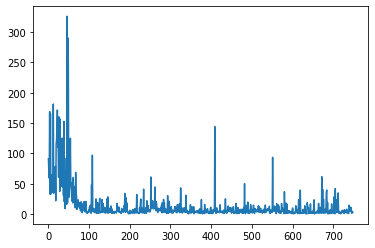

In [ ]:
plt.plot(loss_batch)

In [ ]:
torch.save(model, 'model.torch')

In [ ]:
sample = val_data[2]['sample'].reshape(1, -1)
target = val_data[2]['target'].reshape(1, -1)
tensor2wav('test.wav', sample * 32768, 12000)
outputs = model(sample.cuda().unsqueeze(0)).squeeze(0).cpu()
tensor2wav('test_out.wav', outputs * 32768, 24000)
tensor2wav('test_target.wav', target * 32768, 24000)

In [ ]:
print(outputs, outputs.shape)

tensor([[-0.0974, -0.6396, -0.8779,  ..., -0.8159,  0.2857,  0.2245]],
       grad_fn=<CopyBackwards>) torch.Size([1, 156000])


In [ ]:
print(sample, sample.shape)

tensor([[ 0.0051,  0.0060, -0.0032,  ...,  0.0000,  0.0000,  0.0000]]) torch.Size([1, 66000])


In [ ]:
print(val_data[0]['target'].reshape(1, -1))

tensor([[9.1344e-05, 1.2265e-04, 1.2041e-04,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


In [25]:
#Lite model vs large model, replace names with whatever model you want to test
lite = torch.load('lite.torch').cuda()
large = torch.load('large.torch').cuda()

In [21]:
eval_inds = random.sample(range(len(test_inds)), 300)
eval_data = Subset(test_data, eval_inds)
eval_loader = DataLoader(eval_data, batch_size=10, collate_fn=collate_fn_chunk)

In [29]:
from tqdm import tqdm

In [54]:
loss_metric = nn.MSELoss()

base_loss = []
lite_loss = []
large_loss = []
N = 0

base = torchaudio.transforms.Resample(12000, 24000)

for batch in tqdm(eval_loader):
  samples, targets = batch['sample'], batch['target']
  with torch.no_grad():

    base_pred = base(samples)
    base_loss.append(loss_metric(base_pred, targets))
    samples, targets = samples.cuda(), targets.cuda()

    lite_pred = lite(samples)
    N += samples.shape[0]
    #large_pred = large(samples)
    lite_loss.append(loss_metric(lite_pred, targets).cpu())
    #large_loss.append(loss_metric(large_pred, targets).cpu())






  0%|          | 0/30 [00:00<?, ?it/s]




  3%|▎         | 1/30 [00:01<00:45,  1.56s/it]




  7%|▋         | 2/30 [00:03<00:43,  1.57s/it]




 10%|█         | 3/30 [00:05<00:44,  1.66s/it]




 13%|█▎        | 4/30 [00:06<00:43,  1.65s/it]




 17%|█▋        | 5/30 [00:08<00:42,  1.71s/it]




 20%|██        | 6/30 [00:10<00:40,  1.68s/it]




 23%|██▎       | 7/30 [00:11<00:37,  1.65s/it]




 27%|██▋       | 8/30 [00:13<00:36,  1.66s/it]




 30%|███       | 9/30 [00:14<00:33,  1.61s/it]




 33%|███▎      | 10/30 [00:16<00:32,  1.65s/it]




 37%|███▋      | 11/30 [00:18<00:33,  1.74s/it]




 40%|████      | 12/30 [00:20<00:31,  1.75s/it]




 43%|████▎     | 13/30 [00:21<00:28,  1.67s/it]




 47%|████▋     | 14/30 [00:23<00:28,  1.75s/it]




 50%|█████     | 15/30 [00:25<00:26,  1.78s/it]




 53%|█████▎    | 16/30 [00:27<00:24,  1.78s/it]




 57%|█████▋    | 17/30 [00:28<00:22,  1.72s/it]




 60%|██████    | 18/30 [00:30<00:20,  1.72s/it]




 63%|██████▎   | 19/30 [0

In [50]:
np.array(base_loss).mean() 

0.0004559212

In [51]:
np.array(lite_loss).mean()

0.00043919904

In [55]:
np.array(base_loss).std() / np.sqrt(N)

1.5543495976941718e-06

In [56]:
np.array(lite_loss).std() / np.sqrt(N)

1.5292641641566676e-06